In [68]:
import numpy as np
import cupy as cp 

from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
import seaborn as sns 

In [79]:
kernel = ''' 
#define D2Q9 9
#define NUM_THREADS_2D 16
#define FLUID 0
#define SOLID 1
#define INLET 10
#define OUTLET 30

#define isFalse 0
#define isTrue 1

#define GET_X_2D const long long x = threadIdx.x + blockDim.x*blockIdx.x;
#define GET_Y_2D const long long y = threadIdx.y + blockDim.y*blockIdx.y;
#define GET_IJ const long long ij = ny*x + y;
#define GET_TX_2D const int tx = threadIdx.x;
#define GET_TY_2D const int ty = threadIdx.y;

__device__ int check_if_out_of_domain_2d(long long nx, long long ny, long long x_new,long long y_new){
int is_out_of_domain = isFalse;
if ((x_new < 0) || (y_new < 0)){
    is_out_of_domain = isTrue;
}

if ((x_new >= nx) || (y_new >= ny)){
    is_out_of_domain = isTrue;
}
return is_out_of_domain;

}

__device__ float d_m_equilibrium_2d(int c, float rho, float ux, float uy){
float meq = 0;
switch(c){
    case 0:
        meq = rho;
        break;
    case 1:
        meq = -2 * rho + 3 * rho * (ux * ux + uy * uy);
        break;
    case 2:
        meq = rho - 3 * rho * (ux * ux + uy * uy);
        break;
    case 3:
        meq = rho * ux;
        break;
    case 4:
        meq = - rho * ux;
        break;
    case 5:
        meq = rho * uy;
        break;
    case 6:
        meq = - rho * uy;
        break;
    case 7:
        meq = rho * (ux * ux - uy * uy);
        break;
    case 8:
        meq = rho * ux * uy;
        break;
    default:
        meq = 0;
}
return meq;
}


extern "C" {
__global__ void calc_moment_2d(long long nx, long long ny, int nv, 
float *rho_f, float *ux_f, float *uy_f, int *cx, int *cy, float *fn){
GET_X_2D
GET_Y_2D
GET_IJ 
const long long nxy = nx*ny;
if (x < nx && y < ny){
    rho_f[ij] = 0.0;
    ux_f[ij] = 0.0;
    uy_f[ij] = 0.0;
    for (int c = 0 ; c < nv ; c++){
        rho_f[ij] += fn[nxy*c + ij];
        ux_f[ij] += fn[nxy*c + ij]*cx[c];
        uy_f[ij] += fn[nxy*c + ij]*cy[c];
    }
    ux_f[ij] /= rho_f[ij];
    uy_f[ij] /= rho_f[ij];
}
}

__global__ void calc_equilibrium_2d(long long nx, long long ny, int nv, 
float *rho_f, float *ux_f, float *uy_f, int *cx, int *cy, float *wi, float *feq){
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx*ny;
if (x<nx && y<ny){
    float u_dot_ci;
    float u_square;

    u_square = ux_f[ij]*ux_f[ij] + uy_f[ij]*uy_f[ij];
    for (int c = 0; c < nv ; c++){
        u_dot_ci = ux_f[ij]*cx[c] + uy_f[ij]*cy[c];
        feq[nxy*c + ij] = wi[c]*rho_f[ij]*(1.0 + 3.0*u_dot_ci + 4.5*u_dot_ci*u_dot_ci - 1.5*u_square);
    }

}

}

__global__ void collision_streaming_srt_d2q9(long long nx, long long ny, int nv, float *fn, float *wi,
int *cx, int *cy, float omega, float one_minus_omega, int *geom, float *rho_f, float *ux_f, float *uy_f,
float *feq, int *inv_idx){
__shared__ float fs[D2Q9][NUM_THREADS_2D][NUM_THREADS_2D];
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx*ny;
GET_TX_2D
GET_TY_2D
if (x<nx && y<ny){
    int is_out_of_domain = isFalse;
    int geometry = geom[ij];
    if (!(geometry == SOLID)){
        long long i_new;
        for (int c = 0; c < nv ; c++){
            fs[c][tx][ty] = fn[nxy*c + ij];
        }
        for (int c = 0; c < nv; c++){
            // collision
            fs[c][tx][ty] = one_minus_omega*fs[c][tx][ty] + omega*feq[nxy*c + ij];
            // streaming
            i_new = ny*(x + cx[c]) + (y + cy[c]);
            is_out_of_domain = check_if_out_of_domain_2d(nx, ny, x+cx[c], y+cy[c]);
            if (is_out_of_domain == isFalse){
                geometry = geom[i_new];
                if (geometry == FLUID){
                    fn[nxy*c + i_new] = fs[c][tx][ty];
                }else if (geometry == SOLID){
                    // bounce back scheme
                    fn[nxy*inv_idx[c] + ij] = fs[c][tx][ty];
                }
            }

        }
    }
}

}

__global__ void collision_streaming_mrt_d2q9(long long nx, long long ny, int nv, float *fn, float *wi,
int *cx, int *cy, float omega, float one_minus_omega, int *geom, float *rho_f, float *ux_f, float *uy_f, 
float *feq, int *inv_idx, float *s_mtx){
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx * ny;
GET_TX_2D
GET_TY_2D
if (x < nx & y < ny){
    int is_out_of_domain = isFalse;
    int geometry = geom[ij];
    float fs[D2Q9];
    float m[D2Q9];
    for (int c = 0; c < nv; c++){
        fs[c] = fn[nxy * c + ij];
    }
    float m_eq;
    if (!(geometry == SOLID)){
        long long i_new;
        // convert into moment space
        m[0] = fs[0] + fs[1] + fs[2] + fs[3] + fs[4] + fs[5] + fs[6] + fs[7] + fs[8];
        m[1] = -4*fs[0] - fs[1] - fs[2] - fs[3] - fs[4] + 2*fs[5] + 2*fs[6] + 2*fs[7] + 2*fs[8];
        m[2] = 4*fs[0] - 2*fs[1] - 2*fs[2] - 2*fs[3] - 2*fs[4] + fs[5] + fs[6] + fs[7] + fs[8];
        m[3] = fs[1] - fs[3] + fs[5] - fs[6] - fs[7] + fs[8];
        m[4] = -2*fs[1] + 2*fs[3] + fs[5] - fs[6] - fs[7] + fs[8];
        m[5] = fs[2] - fs[4] + fs[5] + fs[6] - fs[7] - fs[8];
        m[6] = -2*fs[2] + 2*fs[4] + fs[5] + fs[6] - fs[7] - fs[8];
        m[7] = fs[1] - fs[2] + fs[3] - fs[4];
        m[8] = fs[5] - fs[6] + fs[7] - fs[8];

        //collision
        for (int c = 0; c < nv; c++){
            // get m_eq
            m_eq = d_m_equilibrium_2d(c, rho_f[ij], ux_f[ij], uy_f[ij]);
            // collision
            m[c] -= s_mtx[c] * (m[c] - m_eq);
        }

        fs[0] = (1.0/9.0)*m[0] - 1.0/9.0*m[1] + (1.0/9.0)*m[2];
        fs[1] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] + (1.0/6.0)*m[3] - 1.0/6.0*m[4] + (1.0/4.0)*m[7];
        fs[2] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] + (1.0/6.0)*m[5] - 1.0/6.0*m[6] - 1.0/4.0*m[7];
        fs[3] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] - 1.0/6.0*m[3] + (1.0/6.0)*m[4] + (1.0/4.0)*m[7];
        fs[4] = (1.0/9.0)*m[0] - 1.0/36.0*m[1] - 1.0/18.0*m[2] - 1.0/6.0*m[5] + (1.0/6.0)*m[6] - 1.0/4.0*m[7];
        fs[5] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] + (1.0/6.0)*m[3] + (1.0/12.0)*m[4] + (1.0/6.0)*m[5] + (1.0/12.0)*m[6] + (1.0/4.0)*m[8];
        fs[6] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] - 1.0/6.0*m[3] - 1.0/12.0*m[4] + (1.0/6.0)*m[5] + (1.0/12.0)*m[6] - 1.0/4.0*m[8];
        fs[7] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] - 1.0/6.0*m[3] - 1.0/12.0*m[4] - 1.0/6.0*m[5] - 1.0/12.0*m[6] + (1.0/4.0)*m[8];
        fs[8] = (1.0/9.0)*m[0] + (1.0/18.0)*m[1] + (1.0/36.0)*m[2] + (1.0/6.0)*m[3] + (1.0/12.0)*m[4] - 1.0/6.0*m[5] - 1.0/12.0*m[6] - 1.0/4.0*m[8];

        for (int c = 0; c < nv; c++){
            // streaming
            i_new = ny * (x + cx[c]) + (y + cy[c]);
            is_out_of_domain = check_if_out_of_domain_2d(nx, ny, x+cx[c], y+cy[c]);
            if (is_out_of_domain == isFalse){
                geometry = geom[i_new];
                if (geometry == FLUID){
                    fn[nxy * c + i_new] = fs[c];
                } else if (geometry == SOLID) {
                    // bounce back scheme
                    fn[nxy * inv_idx[c] + ij] = fs[c];
                }
            }
        }
    }
}

}


__global__ void boundary_equilibrium_2d(long long nx, long long ny, int nv, 
float *fn, float *wi, int *cx, int *cy, float *u0_in, int *geom){
GET_X_2D
GET_Y_2D
GET_IJ
const long long nxy = nx*ny;
float u_dot_ci;
float u_square;
if (x < nx && y < ny){
    float rho = 0.0;
    float ux = 0.0;
    float uy = 0.0;
    int geometry = geom[ij];
    if (geometry == INLET){
        rho = 1.0;
        ux = u0_in[0];
        uy = u0_in[1];
        
        u_square = ux*ux + uy*uy;
        for (int c = 0; c < nv; c++){
            u_dot_ci = ux*cx[c] + uy*cy[c];
            fn[nxy*c + ij] = wi[c]*rho*(1.0 + 3.0*u_dot_ci + 4.5*u_dot_ci*u_dot_ci - 1.5*u_square);
        }
    }else if (geometry == OUTLET){
        long long ij_src = ny*(x - 1) + y;
        for(int c = 0; c < nv ; c++){
            rho += fn[nxy*c + ij_src];
            ux += fn[nxy*c + ij_src]*cx[c];
            uy *= fn[nxy*c + ij_src]*cy[c];
        }
        ux /= rho;
        uy /= rho;
        u_square = ux*ux +uy*uy;
        for (int c = 0; c < nv ; c++){
            u_dot_ci = ux*cx[c] + uy*cy[c];
            fn[nxy*c + ij] = wi[c]*0.999*(1.0 + 3.0*u_dot_ci + 4.5*u_dot_ci*u_dot_ci - 1.5*u_square);
        }
    }
}

}

}

'''

In [70]:
class LBM(object):
    def __init__(self, geom, tau, ux_in):
        self.geom = geom
        self.nx, self.ny = geom.shape
        self.nx = np.int64(self.nx)
        self.ny = np.int64(self.ny)
        self.nz = np.int64(1)
        self.velocity_model = 'D2Q9'
        self.collision_model = 'mrt'
        self.nv = None
        self.set_velocity_model()

        self.tau = np.float32(tau)
        self.omega = np.float32(1.0 / self.tau)
        self.one_minus_omega = np.float32(1.0 - self.omega)
        self.s_mtx = None
        self.set_relaxation_matrix()

        shape = (self.nv, self.nx, self.ny)
        shape2 = (self.nx, self.ny)
        self.fn = cp.zeros(shape, dtype=cp.float32)
        # self.fn = cp.random.randn(self.nv, self.nx, self.ny, dtype=cp.float32)
        self.feq = cp.zeros(shape, dtype=cp.float32)
        self.rho = cp.zeros(shape2, dtype=cp.float32)
        self.ux = cp.zeros(shape2, dtype=cp.float32)        
        self.uy = cp.zeros(shape2, dtype=cp.float32)
        self.cx = None
        self.cy = None
        self.cb_idx = None
        self.set_velocity_vector()

        self.wi = None
        self.set_weight_parameter()

        
        self.width = 1e-2
        self.nu = 1.512e-5
        self.c_x = None
        self.c_t = None
        self.c_u = None
        self.set_normalize_const()
        print('u0:', ux_in / self.c_u)
        reynolds_number = self.geom.shape[1] * self.c_x * ux_in / self.nu
        print('Reynolds Number: ', reynolds_number)
        self.u_in = cp.array((ux_in / self.c_u, 0.0), dtype=cp.float32)
        self.u_mw = cp.array((0, 0), dtype=cp.float32)
        self.data = []

        self.threads_per_block = (16, 16, 1)
        blocks_per_grid_x = math.ceil(self.nx/self.threads_per_block[0])
        blocks_per_grid_y = math.ceil(self.ny/self.threads_per_block[1])
        blocks_per_grid_z = math.ceil(self.nz/self.threads_per_block[2])
        self.blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y, blocks_per_grid_z)
        self.module = cp.RawModule(code = kernel)
        self.calc_moment = self.module.get_function('calc_moment_2d')
        self.calc_equilibrium = self.module.get_function('calc_equilibrium_2d')
        if self.collision_model == 'srt':
            self.collision_streaming = self.module.get_function('collision_streaming_srt_d2q9')
        elif self.collision_model == 'mrt':
            self.collision_streaming = self.module.get_function('collision_streaming_mrt_d2q9')
        self.apply_boundary = self.module.get_function('boundary_equilibrium_2d')

    def set_relaxation_matrix(self):
        if self.velocity_model == 'D2Q9':
            omega_e = 1.5
            omega_eps = 1.4
            omega_q = 1.5
            self.s_mtx = cp.array([0, omega_e, omega_eps, 0, omega_q, 0, 
                                   omega_q, self.omega, self.omega], dtype=cp.float32)
        else:
            pass

    def set_velocity_model(self):
        if self.velocity_model == 'D2Q9':
            self.nv = 9
        else:
            self.nv = None
        self.nv = np.int32(self.nv)

    def set_velocity_vector(self):
        if self.velocity_model == 'D2Q9':
            cx = []
            cy = []
            cx.extend([0, 1, 0, -1, 0, 1, -1, -1, 1])
            cy.extend([0, 0, 1, 0, -1, 1, 1, -1, -1])
            self.cx = cp.array(cx, dtype=cp.int32)
            self.cy = cp.array(cy, dtype=cp.int32)
            # bounce back index
            self.cb_idx = cp.array((0, 3, 4, 1, 2, 7, 8, 5, 6), dtype=cp.int32)

        else:
            pass

    def set_weight_parameter(self):
        if self.velocity_model == 'D2Q9':
            wi = []
            w0, w1, w2 = 4.0 / 9.0, 1.0 / 9.0, 1.0 / 36.0
            wi.extend([w0])
            wi.extend(4 * [w1])
            wi.extend(4 * [w2])
            self.wi = cp.array(wi, dtype=cp.float32)
        else:
            pass

    def set_normalize_const(self):
        dx = self.width / (self.nx - 1)
        self.c_x = np.float32(dx)
        dt = (1.0 / 3.0) * (self.tau - 0.5) * dx ** 2 / self.nu
        self.c_t = np.float32(dt)
        self.c_u = self.c_x / self.c_t

    def init_dist(self):
        for i in range(self.nv):
            self.fn[i, :, :] = self.wi[i]

    def store_data(self, t):
        rho = self.rho.get()
        ux = self.c_u * self.ux.get()
        uy = self.c_u * self.uy.get()
        u_abs = (ux ** 2 + uy ** 2) ** 0.5
        data = {'t': t, 'rho': rho, 'ux': ux, 'uy': uy, 'u_abs': u_abs}
        self.data.append(data)

    
    def run(self, num_steps):
        self.init_dist()
        for i in tqdm(range(num_steps)):
            args = (self.nx, self.ny, self.nv, self.rho, self.ux, self.uy, self.cx, self.cy, self.fn)
            self.calc_moment(self.blocks_per_grid, self.threads_per_block, args)
            if self.collision_model == 'srt':
                args = (self.nx, self.ny, self.nv, self.rho, self.ux, self.uy, self.cx, self.cy, self.wi, self.feq)
                self.calc_equilibrium(self.blocks_per_grid, self.threads_per_block, args)
            if self.collision_model == 'srt':
                args = (self.nx, self.ny, self.nv, self.fn, self.wi, self.cx, self.cy,
                        self.omega, self.one_minus_omega, self.geom, self.rho,
                        self.ux, self.uy, self.feq, self.cb_idx)
            elif self.collision_model == 'mrt':
                args = (self.nx, self.ny, self.nv, self.fn, self.wi, self.cx, self.cy,
                        self.omega, self.one_minus_omega, self.geom, self.rho,
                        self.ux, self.uy, self.feq, self.cb_idx, self.s_mtx)
                
            self.collision_streaming(self.blocks_per_grid, self.threads_per_block, args)
            
            args = (self.nx, self.ny, self.nv, self.fn, self.wi, self.cx, self.cy, self.u_in, self.geom)
            self.apply_boundary(self.blocks_per_grid, self.threads_per_block, args)

            if i%1000 == 0:
                rho_min = np.min(self.rho.get())
                print(f'step: {i}, rho_min: {rho_min}')
                self.store_data(i)
                sns.heatmap(self.c_u*self.ux.get().T, cmap='jet')
                plt.show()
       



In [71]:
nx = 100
ny = 50 
inlet = 10
outlet = 30
solid = 1 

x_circle = nx//4 
y_circle = ny//2
radius = 5 

geom = cp.zeros((nx, ny), dtype=cp.int32)
geom[0,:] = inlet
geom[-1, :] = outlet 
geom[:, 0] = solid 
geom[:, -1] = solid

for x in range(nx):
    for y in range(ny):
        dis = ((x - x_circle)**2 + (y - y_circle)**2)**0.5
        if dis < radius:
            geom[x, y] = solid

In [80]:
lbm = LBM(geom, 0.58, 1.0)

u0: 0.17814828576345831
Reynolds Number:  334.0281220815125


In [16]:
#geom = cp.zeros((100, 50), dtype = cp.int32)
lbm = LBM(geom, 0.58, 1.0)

In [17]:
lbm.fn.shape

(9, 100, 50)

  0%|          | 0/50000 [00:00<?, ?it/s]

step: 0, rho_min: 1.0


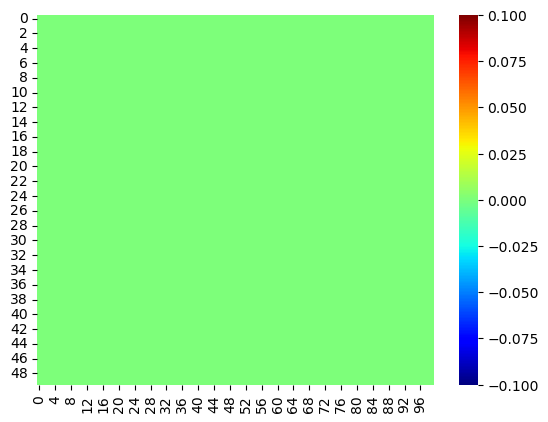

step: 1000, rho_min: 0.9438909292221069


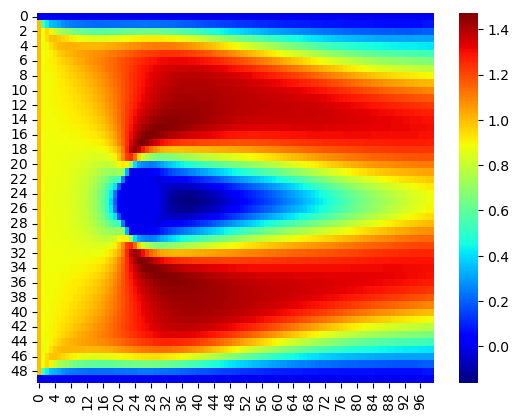

step: 2000, rho_min: 0.9406157732009888


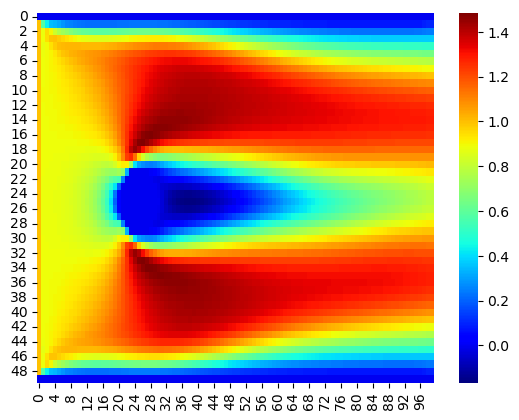

step: 3000, rho_min: 0.940648078918457


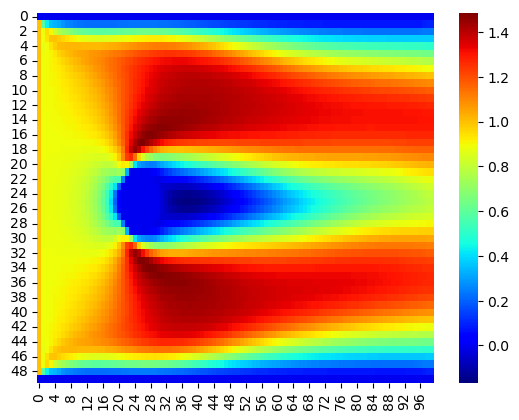

step: 4000, rho_min: 0.9406788349151611


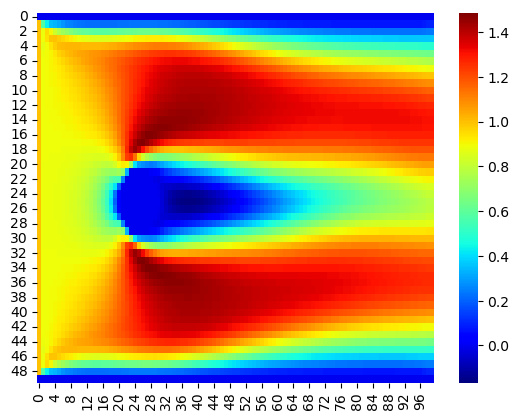

step: 5000, rho_min: 0.9406133890151978


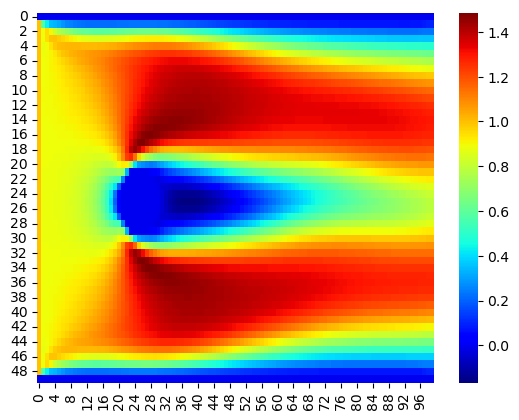

step: 6000, rho_min: 0.940243661403656


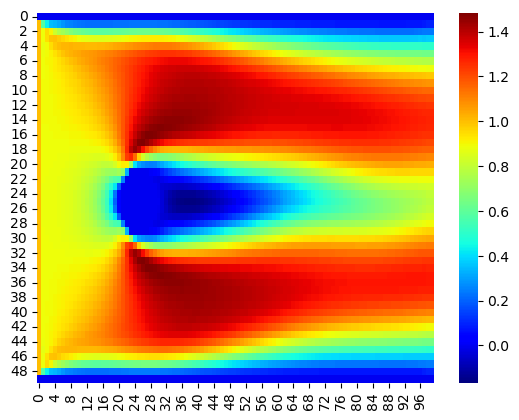

step: 7000, rho_min: 0.9400765895843506


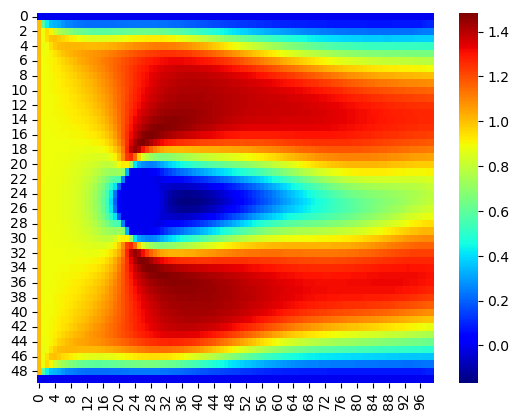

step: 8000, rho_min: 0.9404736757278442


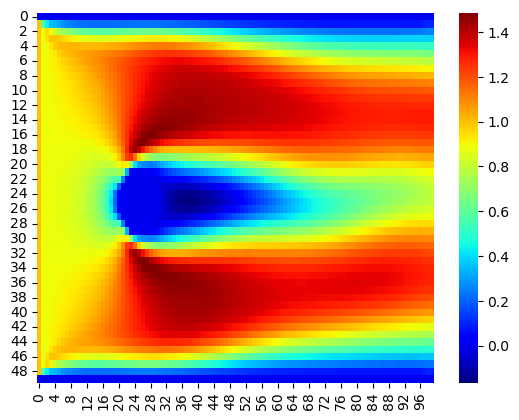

step: 9000, rho_min: 0.9403433203697205


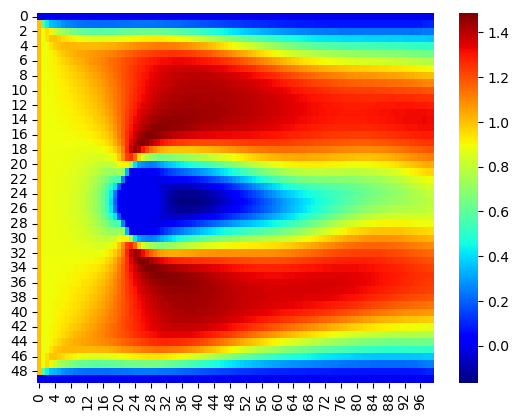

step: 10000, rho_min: 0.9402064681053162


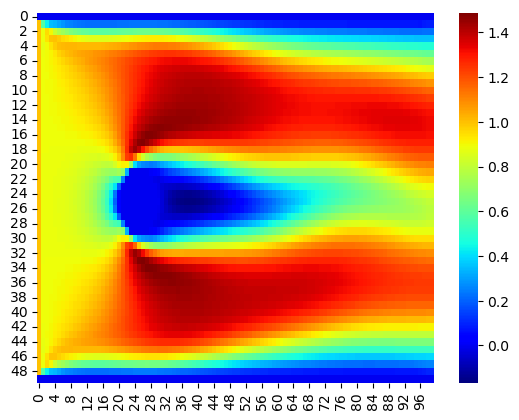

step: 11000, rho_min: 0.9404813051223755


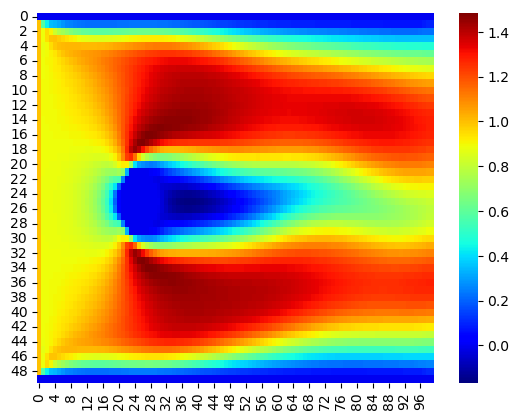

step: 12000, rho_min: 0.9394986033439636


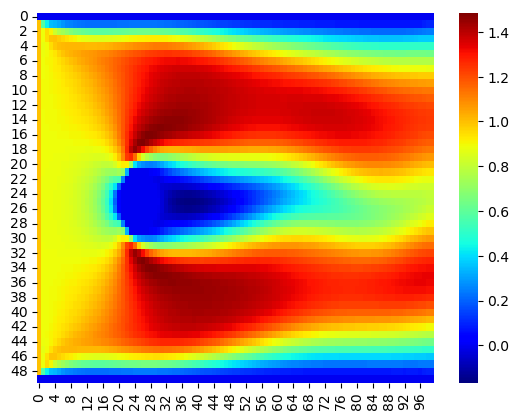

step: 13000, rho_min: 0.9392492771148682


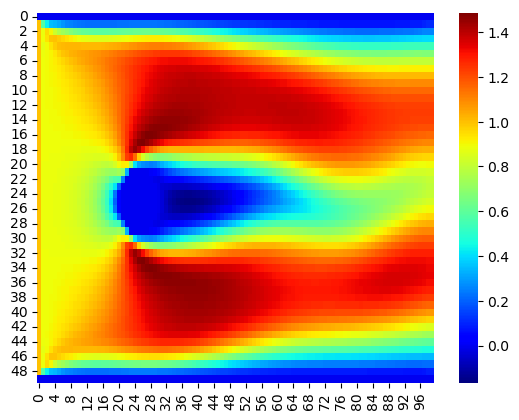

step: 14000, rho_min: 0.9404803514480591


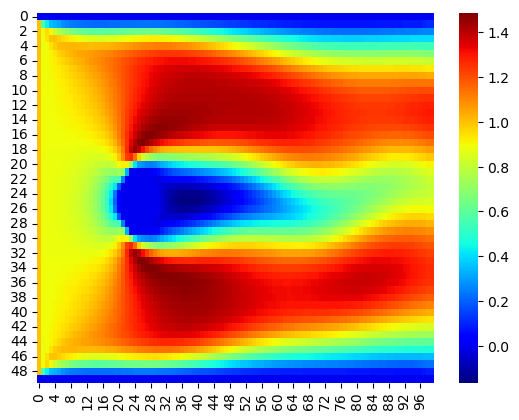

step: 15000, rho_min: 0.9393863677978516


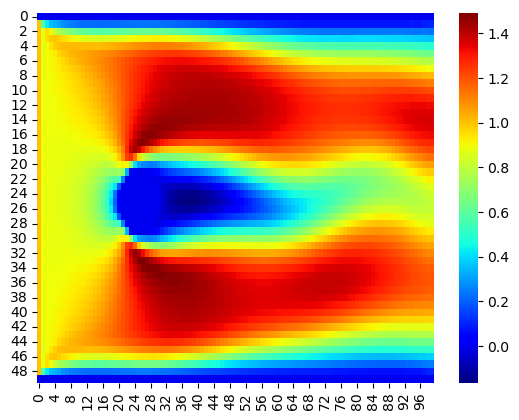

step: 16000, rho_min: 0.9391424655914307


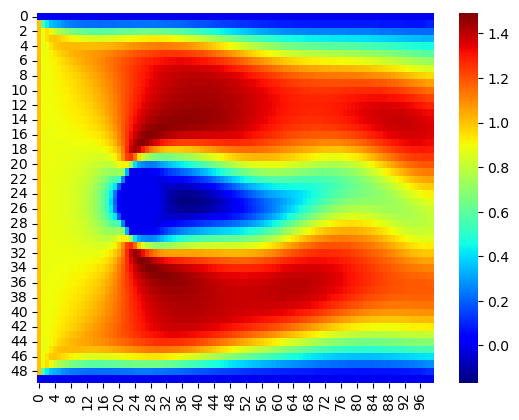

step: 17000, rho_min: 0.9404197931289673


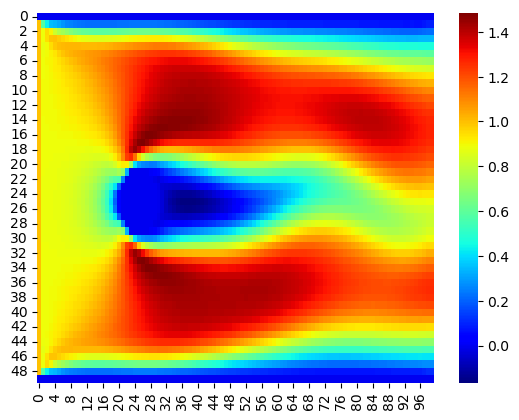

step: 18000, rho_min: 0.9386807680130005


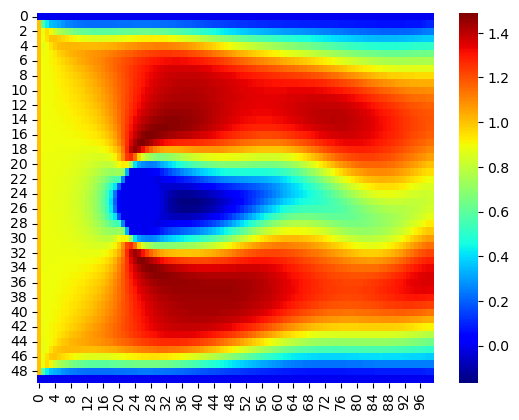

step: 19000, rho_min: 0.9379768371582031


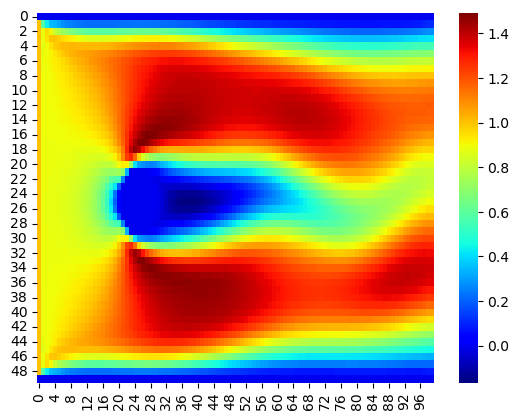

step: 20000, rho_min: 0.939748227596283


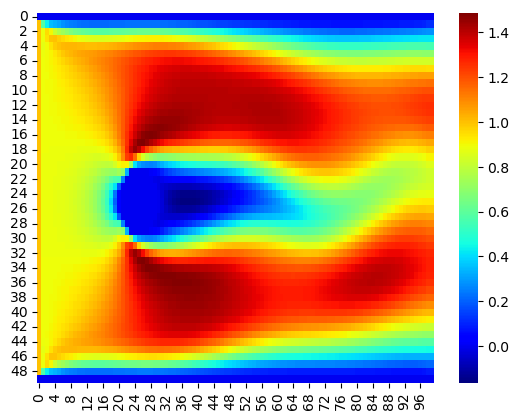

step: 21000, rho_min: 0.939178466796875


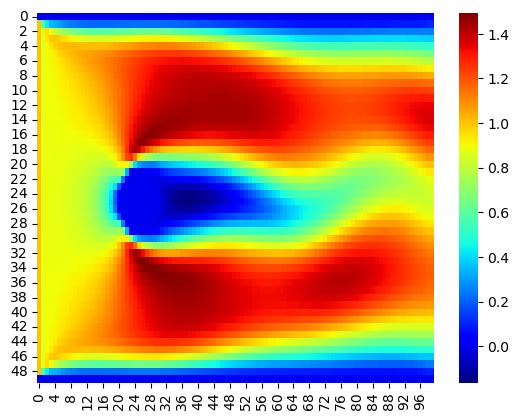

step: 22000, rho_min: 0.9381821751594543


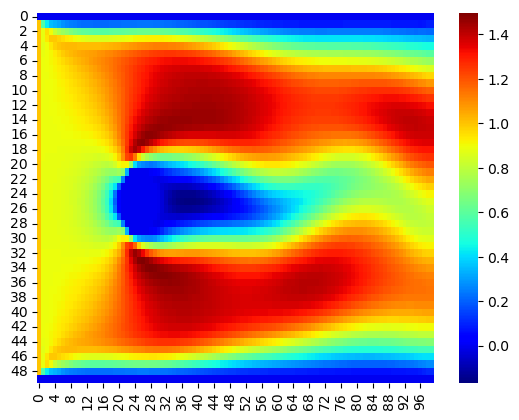

step: 23000, rho_min: 0.9395958185195923


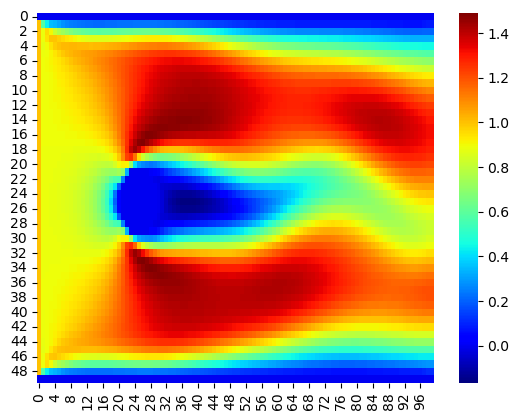

step: 24000, rho_min: 0.9393024444580078


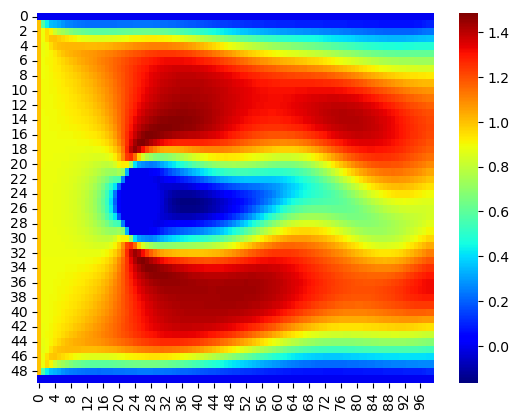

step: 25000, rho_min: 0.937609076499939


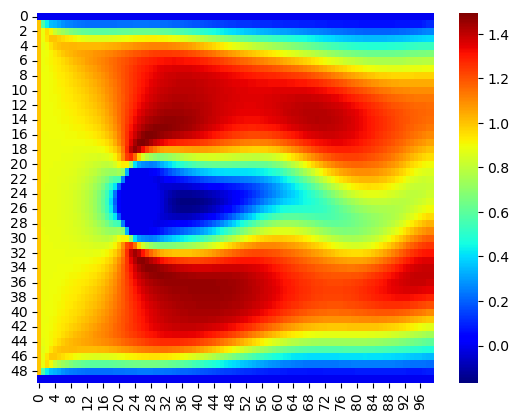

step: 26000, rho_min: 0.9383231401443481


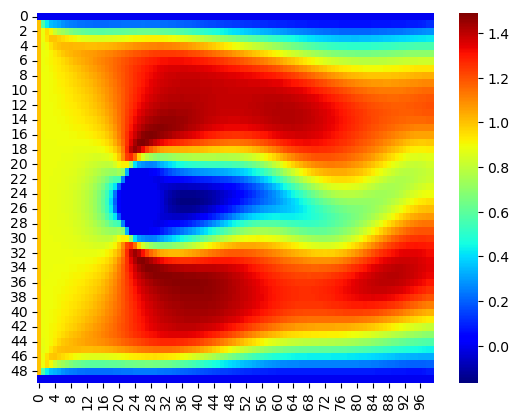

step: 27000, rho_min: 0.9400734305381775


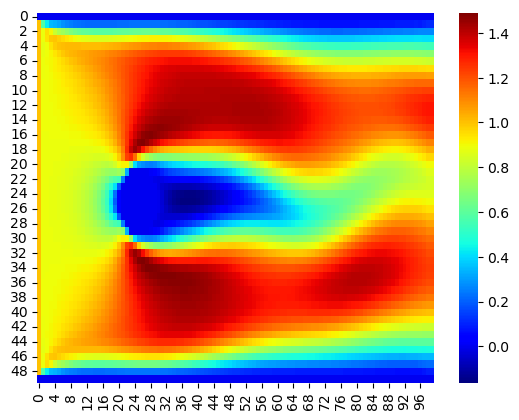

step: 28000, rho_min: 0.9383678436279297


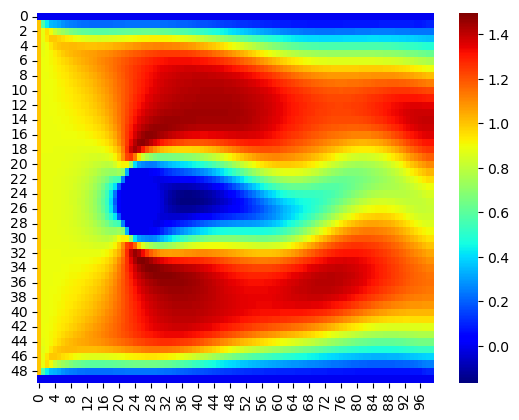

step: 29000, rho_min: 0.9383571147918701


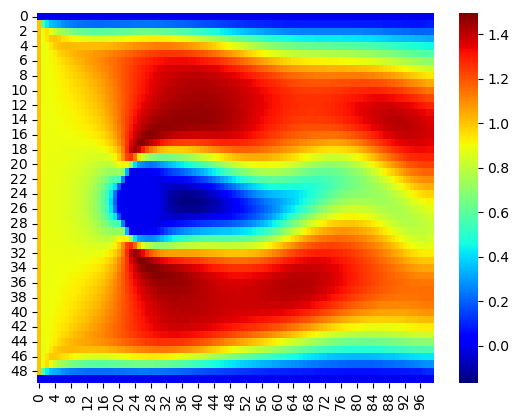

step: 30000, rho_min: 0.9404100775718689


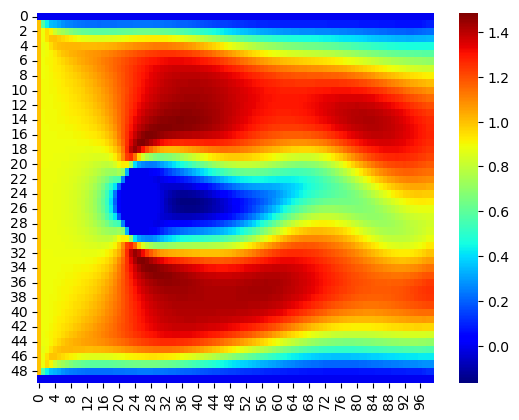

step: 31000, rho_min: 0.9384048581123352


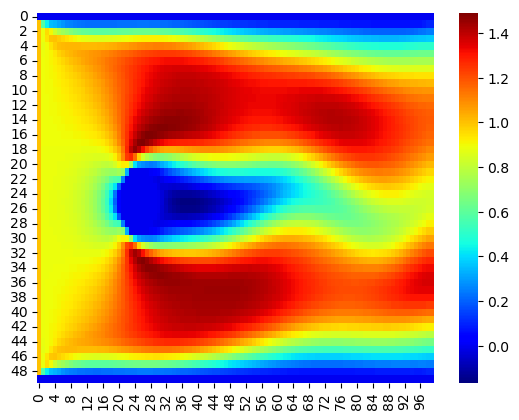

step: 32000, rho_min: 0.937471866607666


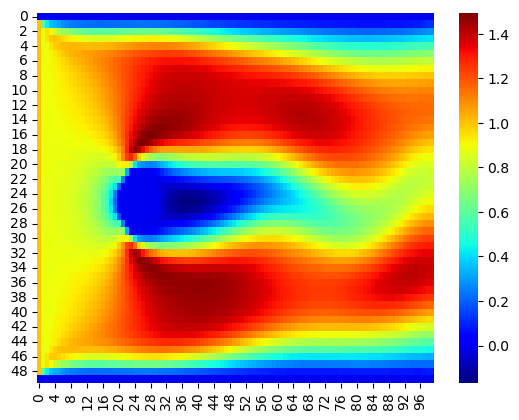

step: 33000, rho_min: 0.9392889142036438


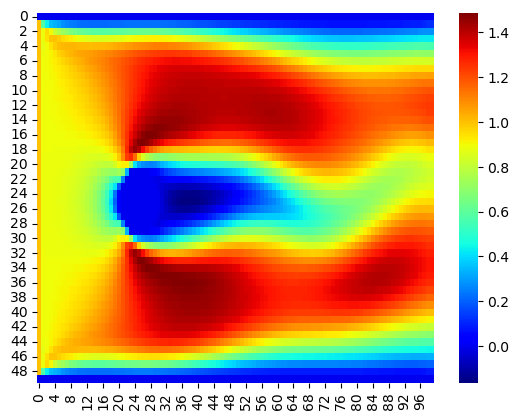

step: 34000, rho_min: 0.9393225312232971


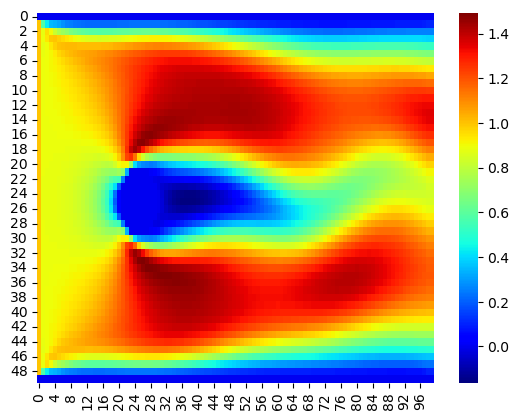

step: 35000, rho_min: 0.9380273818969727


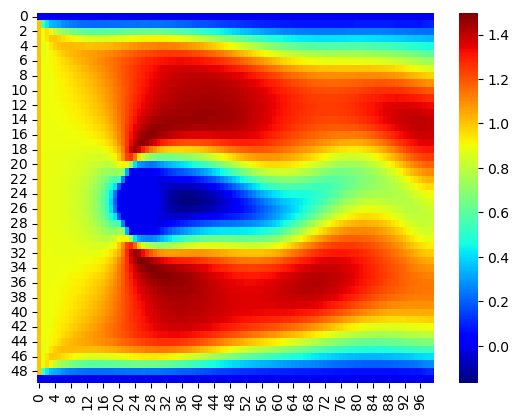

step: 36000, rho_min: 0.9390960335731506


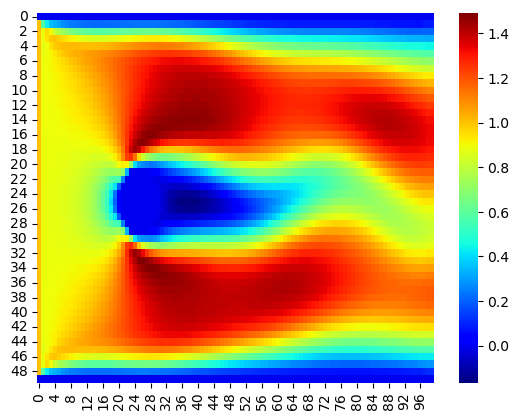

step: 37000, rho_min: 0.9396712183952332


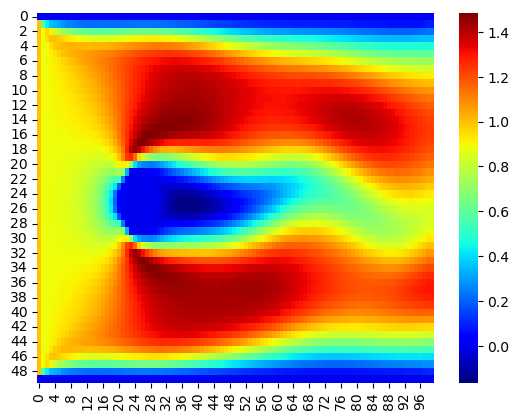

step: 38000, rho_min: 0.9377484321594238


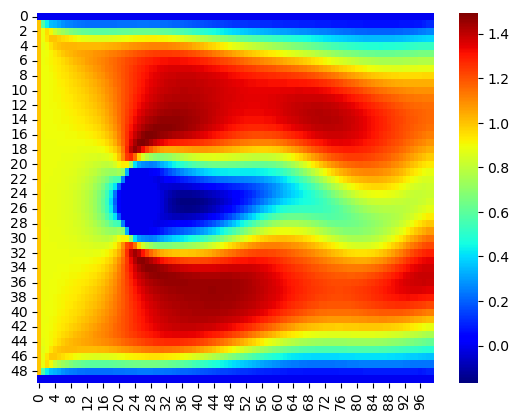

step: 39000, rho_min: 0.9378970265388489


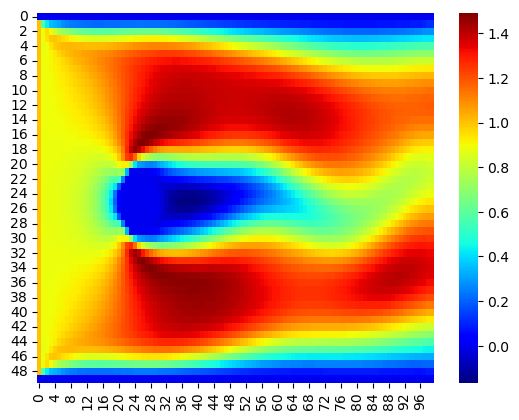

step: 40000, rho_min: 0.9403102397918701


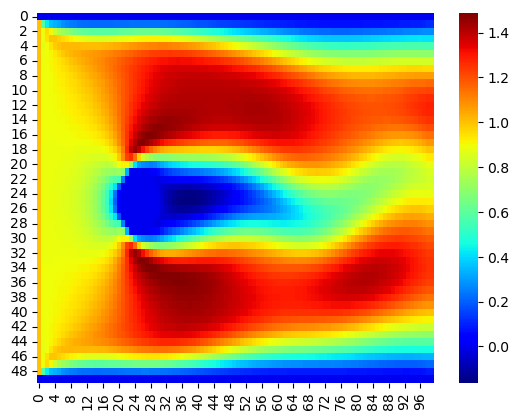

step: 41000, rho_min: 0.9386332035064697


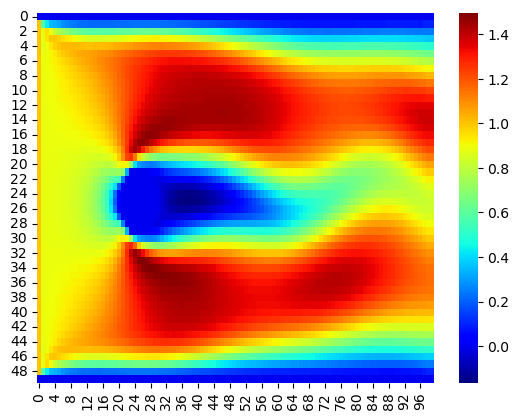

step: 42000, rho_min: 0.9381121397018433


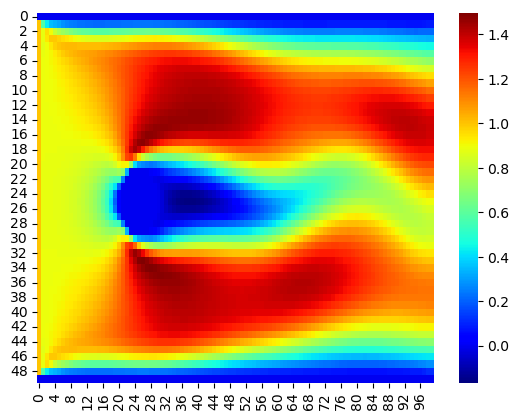

step: 43000, rho_min: 0.9400702118873596


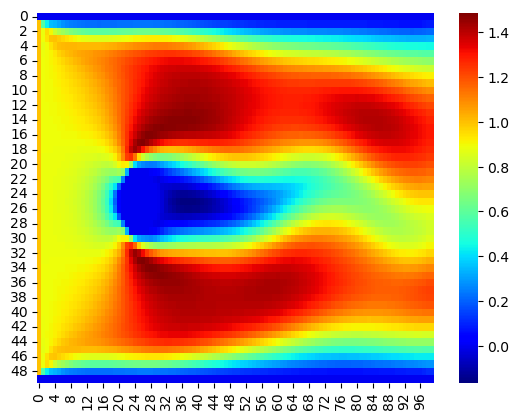

step: 44000, rho_min: 0.9388258457183838


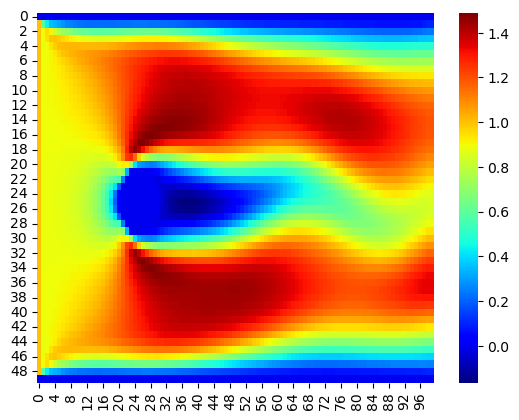

step: 45000, rho_min: 0.9374421834945679


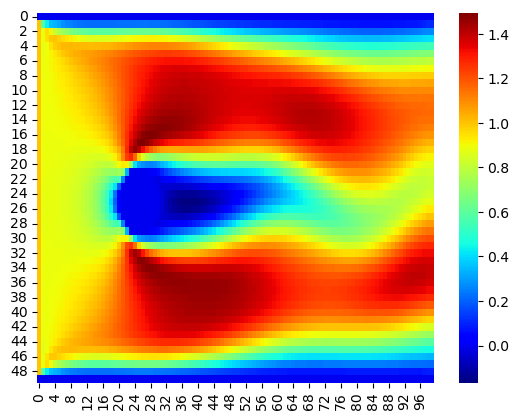

step: 46000, rho_min: 0.9387446045875549


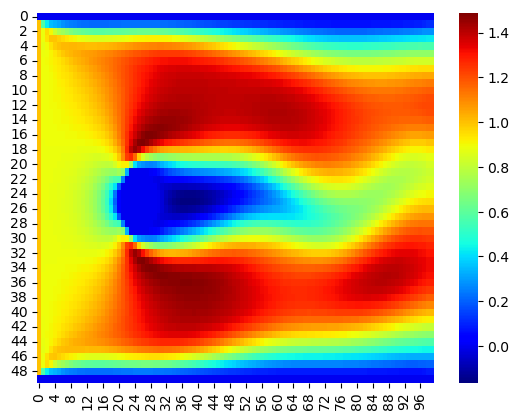

step: 47000, rho_min: 0.9397153258323669


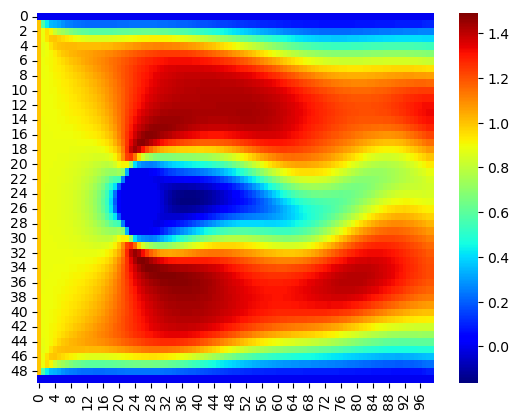

step: 48000, rho_min: 0.9381507039070129


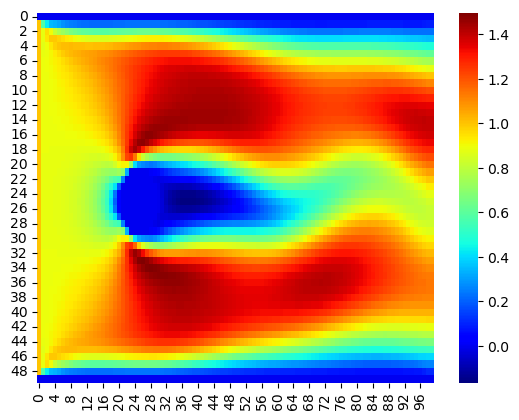

step: 49000, rho_min: 0.9386526942253113


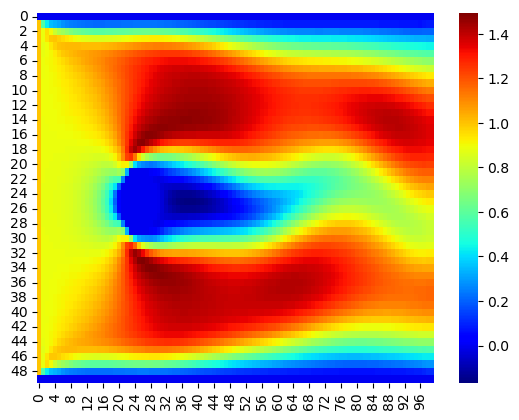

In [81]:
lbm.run(num_steps = 50000)

In [29]:
lbm.wi

array([0.44444445, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.02777778, 0.02777778, 0.02777778, 0.02777778], dtype=float32)

In [28]:
lbm.feq

array([[[0.44444445, 0.44444445, 0.44444445, ..., 0.44444445,
         0.44444445, 0.44444445],
        [0.44444445, 0.44444445, 0.44444445, ..., 0.44444445,
         0.44444445, 0.44444445],
        [0.44444445, 0.44444445, 0.44444445, ..., 0.44444445,
         0.44444445, 0.44444445],
        ...,
        [0.44444445, 0.44444445, 0.44444445, ..., 0.44444445,
         0.44444445, 0.44444445],
        [0.44444445, 0.44444445, 0.44444445, ..., 0.44444445,
         0.44444445, 0.44444445],
        [0.44444445, 0.44444445, 0.44444445, ..., 0.44444445,
         0.44444445, 0.44444445]],

       [[0.11111111, 0.11111111, 0.11111111, ..., 0.11111111,
         0.11111111, 0.11111111],
        [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111,
         0.11111111, 0.11111111],
        [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111,
         0.11111111, 0.11111111],
        ...,
        [0.11111111, 0.11111111, 0.11111111, ..., 0.11111111,
         0.11111111, 0.11111111],
        [0.1

In [10]:
lbm.rho

array([[-0.17609906,  4.87909   ,  1.1015196 , ..., -2.5067067 ,
         2.164655  , -6.613145  ],
       [ 7.087055  ,  2.48809   , -2.5224676 , ..., -1.3459376 ,
        -2.5510237 ,  0.19554517],
       [-1.3537478 , -1.2949015 , -0.19280624, ...,  3.6775873 ,
         0.21816874,  3.1920633 ],
       ...,
       [ 3.6680684 , -6.165983  ,  4.6410794 , ..., -1.444665  ,
        -0.48083407,  3.1139572 ],
       [-0.40005517,  1.7280042 ,  2.6405592 , ...,  2.2949972 ,
         1.6640483 , -0.5025221 ],
       [ 7.207192  , -0.9734116 ,  6.858009  , ...,  2.6316066 ,
         3.9045968 , -2.695284  ]], dtype=float32)

In [11]:
lbm.fn.sum(axis = 0)

array([[-0.17609894,  4.8790903 ,  1.1015196 , ..., -2.5067067 ,
         2.1646552 , -6.6131454 ],
       [ 7.087055  ,  2.4880898 , -2.522468  , ..., -1.3459376 ,
        -2.5510237 ,  0.1955452 ],
       [-1.3537478 , -1.2949015 , -0.192806  , ...,  3.677587  ,
         0.21816874,  3.1920629 ],
       ...,
       [ 3.6680684 , -6.165983  ,  4.6410794 , ..., -1.444665  ,
        -0.4808339 ,  3.1139572 ],
       [-0.40005517,  1.7280042 ,  2.6405592 , ...,  2.2949967 ,
         1.6640482 , -0.50252175],
       [ 7.2071915 , -0.9734116 ,  6.8580084 , ...,  2.6316066 ,
         3.9045968 , -2.695284  ]], dtype=float32)